In [1]:
import os
import random
import utils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tifffile import imread
from matplotlib.patches import Rectangle
from skimage import measure, morphology

np.set_printoptions(precision = 2)
np.set_printoptions(suppress  = True)

In [2]:
model  = tf.keras.models.load_model('model_segmentation.keras')
img    = imread('data/multi_recorte_2.tif')
mask   = mpimg.imread('data/multi_recorte_2.png')[:,:,0]
mask   = utils.convert_8bits(mask)

In [3]:
# Parameters
Nx, Ny, Nz = img.shape
Nw   = 256
step = 100

# Index images
indx_x = np.unique(np.concatenate(([np.arange(0, Nx-Nw, step)], [np.array([Nx-Nw])]), axis = 1))
indx_y = np.unique(np.concatenate(([np.arange(0, Ny-Nw, step)], [np.array([Ny-Nw])]), axis = 1))

N      = indx_x.size*indx_y.size

# Cut images
cntr   = 0
X_test = np.zeros((N, Nw, Nw, Nz))
for i in indx_x:
    for j in indx_y:
        i_idx = np.arange(i, i+Nw)
        j_idx = np.arange(j, j+Nw)
        block = img[i_idx[:, None], j_idx[None, :], :]
        block = utils.convert_8bits(block)
        X_test[cntr] = block
        cntr  += 1

# Predict images
with tf.device('/cpu:0'):
    Y_test_pred = model.predict(X_test, verbose=0)

In [4]:
cntr = 0
bufr_1 = np.zeros((Nx, Ny, Nz))
bufr_2 = np.zeros((Nx, Ny, Nz))
for i in indx_x:
    for j in indx_y:
        i_idx = np.arange(i, i+Nw)
        j_idx = np.arange(j, j+Nw)
        mask_predi  = Y_test_pred[cntr]
        bufr_1[i_idx[:, None], j_idx[None, :], :] = bufr_1[i_idx[:, None], j_idx[None, :], :] + mask_predi;
        bufr_2[i_idx[:, None], j_idx[None, :], :] = bufr_2[i_idx[:, None], j_idx[None, :], :] + 1;
        cntr  += 1


mask_preditions = utils.normalize(bufr_1/bufr_2)[:,:,0]

Number of objects: 868


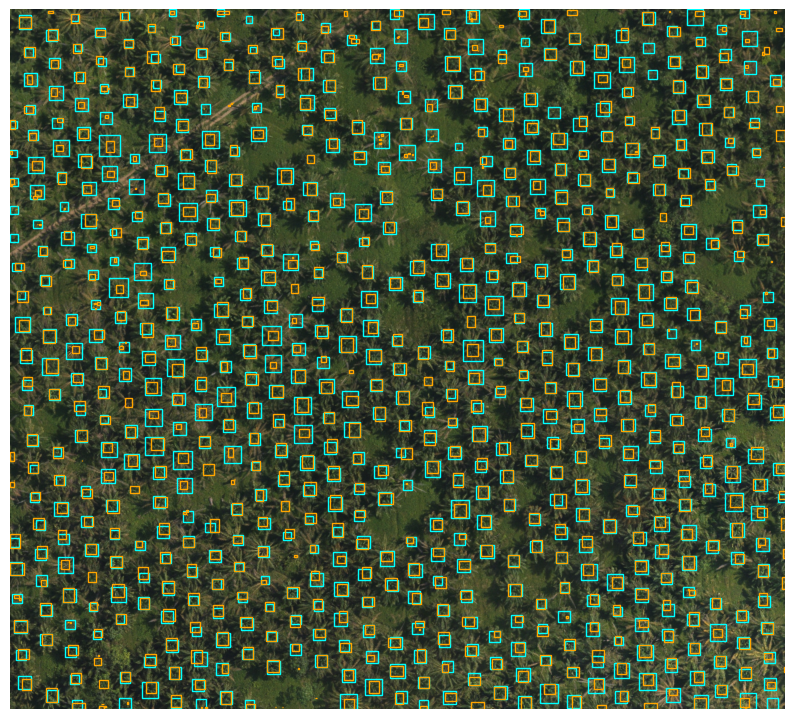

In [5]:
# Convert to 8 bits image
mask_thresh = utils.convert_8bits(mask)
mask_preditions_thresh = utils.convert_8bits(mask_preditions > 0.5)

# Close open circle countours
mask_preditions_thresh = morphology.closing(mask_preditions_thresh, morphology.square(10))

# Label the objects in the binary image
mask_labels, num_objects = measure.label(mask_thresh, background=0, return_num=True)
mask_preditions_labels, num_objects_2 = measure.label(mask_preditions_thresh, background=0, return_num=True)

# Get the properties of the labeled regions
true_regions  = measure.regionprops(mask_labels)
pred_regions  = measure.regionprops(mask_preditions_labels)

print(f'Number of objects: {num_objects_2}')

fig, axs = plt.subplots(figsize = (10,10))
axs.imshow(img)
axs.axis('off')

# Draw rectangles around each object
for region in true_regions:
    minr, minc, maxr, maxc = region.bbox
    rect = Rectangle((minc, minr), maxc - minc, maxr - minr, 
                     edgecolor='cyan', facecolor='none', linewidth=1)
    axs.add_patch(rect)

# Draw rectangles around each object
for region in pred_regions:
    minr, minc, maxr, maxc = region.bbox
    rect = Rectangle((minc, minr), maxc - minc, maxr - minr, 
                     edgecolor='orange', facecolor='none', linewidth=1)
    axs.add_patch(rect)

plt.show()

In [6]:
# Define a function to check intersection between two rectangles
def rectangles_intersect(bbox1, bbox2):
    minr1, minc1, maxr1, maxc1 = bbox1
    minr2, minc2, maxr2, maxc2 = bbox2
    return not (maxr1 < minr2 or maxr2 < minr1 or maxc1 < minc2 or maxc2 < minc1)

# Initialize the count of intersected rectangles
intersected_count = 0

# Check each pair of bounding boxes for intersection
for region1 in true_regions:
    for region2 in pred_regions:
        if rectangles_intersect(region1.bbox, region2.bbox):
            intersected_count += 1
            break  # Only count each intersecting region once

print(f'Number of intersected rectangles: {intersected_count}')

Number of intersected rectangles: 661


In [7]:
661/667

0.9910044977511244

In [8]:
# Detect non-intersecting regions
non_intersecting_regions1 = []

# Check regions in regions1 against all regions in regions2
for region1 in true_regions:
    intersects = False
    for region2 in pred_regions:
        if rectangles_intersect(region1.bbox, region2.bbox):
            intersects = True
            break
    if not intersects:
        non_intersecting_regions1.append(region1)

print(f'Number of non-intersecting regions in regions1: {len(non_intersecting_regions1)}')

Number of non-intersecting regions in regions1: 6


In [11]:
# Detect non-intersecting regions
non_intersecting_regions2 = []

# Check regions in regions1 against all regions in regions2
for region2 in pred_regions:
    intersects = False
    for region1 in true_regions:
        if rectangles_intersect(region1.bbox, region2.bbox):
            intersects = True
            break
    if not intersects:
        non_intersecting_regions2.append(region2)

print(f'Number of non-intersecting regions in regions2: {len(non_intersecting_regions2)}')

Number of non-intersecting regions in regions2: 86


In [12]:
86+661

747